In [1]:
import torch
import torch.nn as nn
import yaml
import einops
import torchvision
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import umap.umap_ as umap
from utils import make_coord_grid
import yaml
from datasets import make as make_dataset
from models import make as make_model
import pickle
from sklearn.manifold import TSNE
import os
from glob import glob
import ipywidgets as widgets
from ipywidgets import interact_manual
import matplotlib.pyplot as plt
import numpy as np
from datasets.fmri_dataloader import DataModule
from patchembed import PatchEmbed
from mamba_ssm import Mamba
from mamba_ssm.modules.block import Block
from mamba_ssm.ops.triton.layer_norm import RMSNorm
import math
import matplotlib.ticker as ticker
plt.rcParams["figure.figsize"] = (7, 5) # Sets default figure size

In [4]:
import matplotlib.font_manager as fm
plt.rcParams["font.family"] = "serif"
print(fm.findfont(plt.rcParams["font.family"][0]))

/global/cfs/cdirs/m4727/mamba-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf


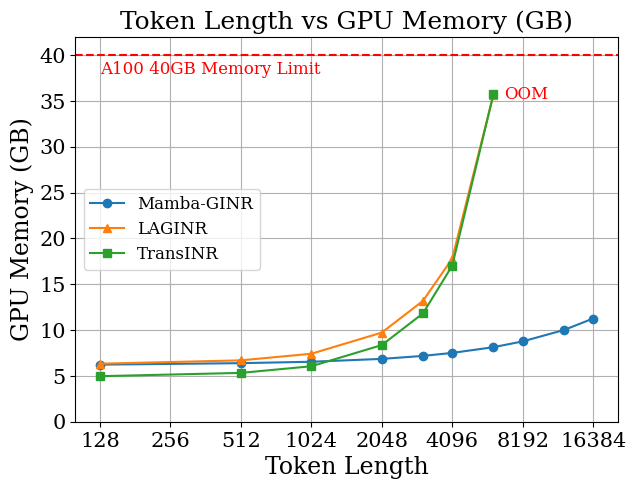

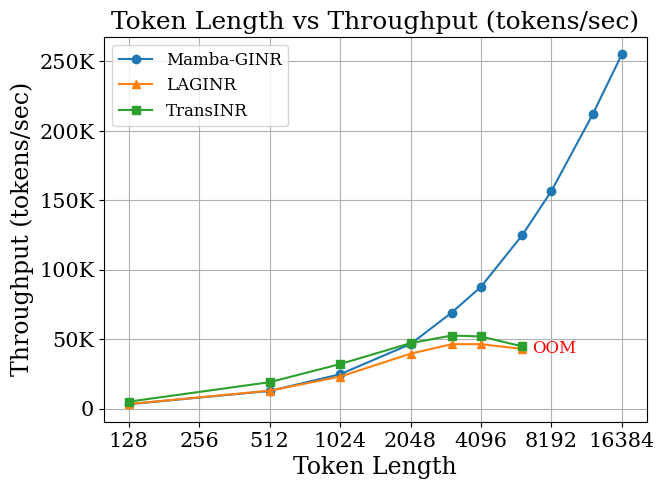

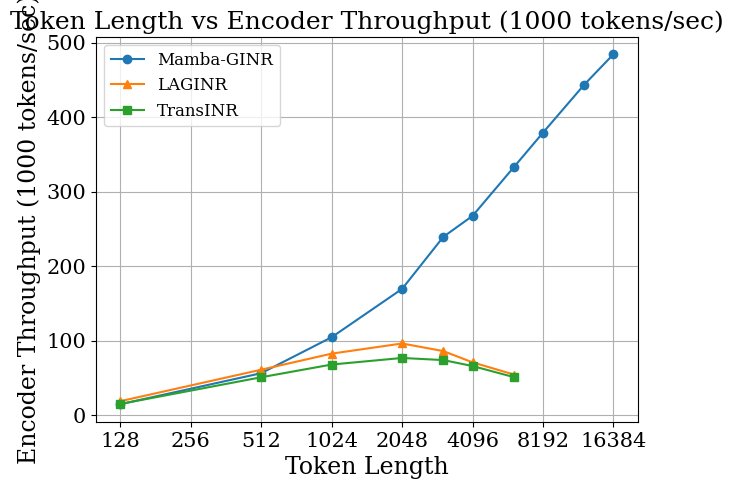

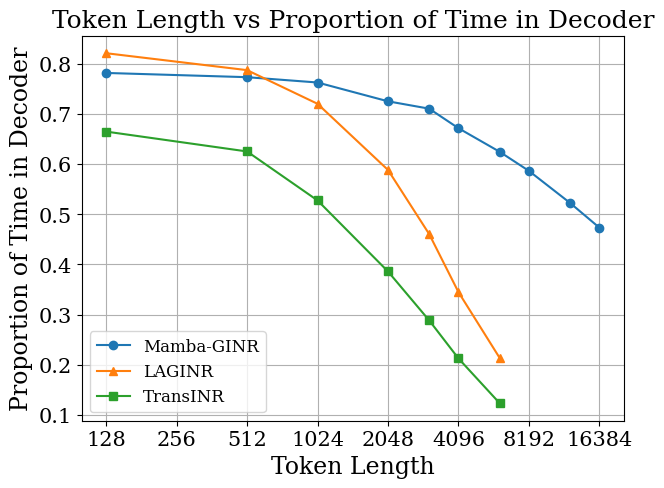

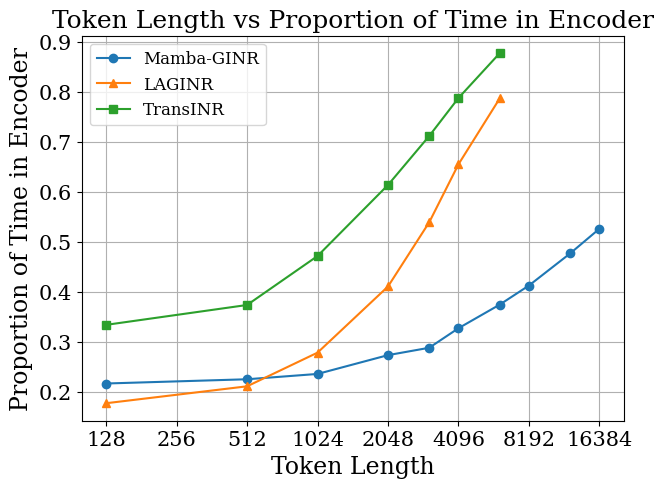

In [72]:

models = {
        "Mamba-GINR": 'o',
        "LAGINR": '^',
        "TransINR": 's'
    }


for metric, ylabel in [("gpu_memory_mb", "GPU Memory (GB)"), ("tokens_per_sec", "Throughput (tokens/sec)"), ("tokens_per_encoder_sec", "Encoder Throughput (1000 tokens/sec)"), ("prop_decoder", "Proportion of Time in Decoder"), ("prop_encoder", "Proportion of Time in Encoder")]:
    plt.figure()
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    

    if metric == "gpu_memory_mb":
        plt.axhline(y=40000, color='r', linestyle='--')
        plt.text(x=128, y=38000, s="A100 40GB Memory Limit", fontsize=12, color="red")
        plt.text(x=6800, y=35200, s="OOM", fontsize=12, color="red")
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5000))
        plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{int(x/1000)}" if x != 0 else "0"))
        plt.ylim(0, 42000)
    elif metric == "tokens_per_sec":  
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50000))
        plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{int(x/1000)}K" if x != 0 else "0"))
        plt.text(x=6800, y=40000, s="OOM", fontsize=12, color="red")
    
    for model_name in models.keys():
        
        with open(f'compute_exp_arrays_{model_name}_{metric}','rb') as f: 
            x_vals, y_vals = pickle.load(f)
            
        plt.plot(
            x_vals,
            y_vals,
            marker=models[model_name],
            label=model_name
        )
    plt.xscale("log", base=2)
    plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.gca().ticklabel_format(style='plain', axis='x')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Token Length", fontsize = 17)
    plt.ylabel(ylabel, fontsize = 17)
    plt.title(f"Token Length vs {ylabel}", fontsize = 18)
    
    
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(f"compute_figs/{metric}.png", dpi = 300)
    
    plt.show()
    plt.close()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (metric, ylabel, label) in zip(
    axes,
    [
        ("gpu_memory_mb", "GPU Memory (GB)", "a"),
        ("tokens_per_sec", "Throughput (tokens/sec)", "b"),
    ],
):
    if metric == "gpu_memory_mb":
        ax.axhline(y=40000, color="r", linestyle="--")
        ax.text(128, 38000, "A100 40GB Memory Limit", fontsize=15, color="black")
        ax.text(6800, 35200, "OOM", fontsize=15, color="red", fontweight='bold')
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: f"{int(x/1000)}" if x != 0 else "0")
        )
        ax.set_ylim(0, 42000)

    elif metric == "tokens_per_sec":
        ax.yaxis.set_major_locator(ticker.MultipleLocator(40000))
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: f"{int(x/1000)}K" if x != 0 else "0")
        )
        ax.text(6800, 40000, "OOM", fontsize=15, color="red", fontweight='bold')

    # plot curves
    for model_name in models.keys():
        with open(f"compute_exp_arrays_{model_name}_{metric}", "rb") as f:
            x_vals, y_vals = pickle.load(f)
            print(f"{model_name}, {y_vals[6]}")

        ax.plot(
            x_vals,
            y_vals,
            marker=models[model_name],
            label=model_name,
        )

    ax.set_xscale("log", base=2)
    ax.grid(axis='y')
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(style="plain", axis="x")
    ax.set_xticks(ax.get_xticks())
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    ax.set_xlabel("Token Length", fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(f"({label}) Token Length vs {ylabel}", fontsize=18)
    #ax.grid(True)
    ax.set_xlim(80, 18384)

# Shared legend
axes[0].legend(fontsize=15)

axes[0].annotate(
    "",  # no text
    xy=(6144, 35500),   # arrow tip
    xytext=(6144, 8000),  # arrow tail
    arrowprops=dict(arrowstyle="<->", color="red", lw=1),
)
axes[0].text(6400, 22000, "4.39x", fontsize=15, color="red")


axes[1].annotate(
    "",  # no text
    xy=(6144, 125000),   # arrow tip
    xytext=(6144, 45000),  # arrow tail
    arrowprops=dict(arrowstyle="<->", color="red", lw=1),
)

axes[1].text(6400, 85000, "2.91x", fontsize=15, color="red")



plt.tight_layout()
plt.savefig("compute_figs/gpu_memory_and_tokens.png", dpi=300)
plt.show()
plt.close()


Mamba-GINR, 8130.5390625
LAGINR, 35696.7099609375
TransINR, 35714.95849609375
Mamba-GINR, 124855.59084167336
LAGINR, 42959.16514553195
TransINR, 44858.1889051555


In [2]:
data_module = DataModule('./cfgs/hcp_data_all_config.yaml')
data_module.setup()
train_loader = data_module.train_dataloader()
test_loader = data_module.val_dataloader()

Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600


In [3]:
class LAINRDecoder(nn.Module):
    def __init__(self, feature_dim, input_dim, output_dim, sigma_q, sigma_ls, n_patches, hidden_dim = 256, context_dim = None):
        super().__init__()
        self.layer_num = len(sigma_ls)
        self.n = feature_dim//(2*input_dim)
        self.omegas = torch.logspace(1, math.log10(sigma_q), self.n)
        self.patch_num = int(math.sqrt(n_patches))
        
        '''self.omegas_l = {str(sig_l):torch.logspace(1, math.log10(sig_l), self.n) for sig_l in sigma_ls}
        self.bandwidth_lins_lins = nn.ModuleDict({
            str(sig_l): nn.Linear(feature_dim, hidden_dim) for sig_l in sigma_ls
        })
        self.modulation_lins = nn.ModuleDict({
            str(sig_l): nn.Linear(hidden_dim, hidden_dim) for sig_l in sigma_ls
        })'''

        self.alpha = 10.0

        self.omegas_l = [torch.logspace(1, math.log10(sigma_ls[i]), self.n) for i in range(self.layer_num)]

        self.query_lin = nn.Linear(feature_dim, hidden_dim)

        #self.modulation_ca = PerPixelCrossAttention(query_dim = hidden_dim, heads=2)
        self.modulation_ca = SharedTokenCrossAttention(query_dim = hidden_dim, heads=2)
        
        self.bandwidth_lins = nn.ModuleList([
            nn.Linear(feature_dim, hidden_dim) for i in range(self.layer_num)
                                       ])
        
        self.modulation_lins = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for i in range(self.layer_num)
        ])

        self.hv_lins = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(len(sigma_ls) - 1)
        ])

        self.out_lins = nn.ModuleList([
            nn.Linear(hidden_dim, output_dim) for _ in range(len(sigma_ls))
        ])
        self.act = nn.ReLU()
        

    def calc_gamma(self, x, omegas):
        #x is passed as H*W, D
        L = x.shape[0]
        coords = x.unsqueeze(-1)  # (H*W, 2, 1)
        omegas = omegas.view(1, 1, -1).to(x.device)  # (1, 1, F)
        
        
        arg = torch.pi * coords * omegas  # shape: (B, 2, F)
        sin_part = torch.sin(arg)
        cos_part = torch.cos(arg)
        
        gamma = torch.cat([sin_part, cos_part], dim=-1).view(L, -1)  
        
        return gamma

    def get_patch_index(self, grid, D, H, W, T):
        """
        grid: (num_points, 4) tensor where columns are [d, h, w, t]
              each coordinate is normalized to [0, 1)
        Order: flatten W first, then H, then D, then T
        """
        z = grid[:, 0]  # D dimension
        y = grid[:, 1]  # H dimension
        x = grid[:, 2]  # W dimension
        t = grid[:, 3]  # T dimension
    
        # Convert normalized coords to integer indices
        z_idx = (z * D).to(torch.int32)
        y_idx = (y * H).to(torch.int32)
        x_idx = (x * W).to(torch.int32)
        t_idx = (t * T).to(torch.int32)
    
        # Flatten: W → H → D → T
        return (((t_idx * D + z_idx) * H + y_idx) * W + x_idx)
    
    
    def approximate_relative_distances(self, target_index, D, H, W, T, m):
        alpha = self.alpha
        N = D * H * W * T
        t = target_index / N
        token_positions = torch.tensor([(i + 0.5) / m for i in range(m)],
                                        device=target_index.device)
    
        rel_distances = -1 * alpha * torch.stack([
            torch.abs((t - s) ** 2) for s in token_positions
        ], dim=0)
        return rel_distances

    '''def get_patch_index(self, grid, H, W):
        y = grid[:, 0]
        x = grid[:, 1]
        row = (y * H).to(torch.int32)
        col = (x * W).to(torch.int32)
        return row * W + col  # index in [0, N-1]

    def approximate_relative_distances(self, target_index, H, W, m):
        alpha = self.alpha
        N = H * W  
        t = target_index / N
        token_positions = torch.tensor([(i + 0.5) / m for i in range(m)])
    
        rel_distances = -1*alpha*torch.stack([torch.abs((t - s)**2) for s in token_positions], dim = 0)
        return rel_distances'''

    def forward(self, x, tokens, shape):
        D, H, W, T = shape
        B, query_shape = x.shape[0], x.shape[1]
        x = x.view(B, -1, x.shape[-1]) #B, HW, 2
        #print(f'query shape is {x.shape[1:]}')
        grid = x[0]
        indexes = self.get_patch_index(grid, D, H, W, T)
        rel_distances = self.approximate_relative_distances(indexes, D, H, W, T, len(tokens[0]))
        bias = rel_distances.transpose(1, 0)
        bias = einops.repeat(bias, 'l n -> b l n', b=B) #B, L, HW
        x_q = einops.repeat(self.calc_gamma(x[0], self.omegas), 'l d -> b l d', b=B) #B, HW, input_dim
        #print(f'x_q shape is {x_q.shape}')
        x_q = self.act(self.query_lin(x_q))


        #(B, HW, 1, D)
        #(B, HW, L, D)

        
        '''tokens = einops.repeat(tokens, 'b l d -> b p l d', p=query_shape[0]*query_shape[1])
        modulation_vector = self.modulation_ca(x_q.unsqueeze(2), context = tokens).squeeze(2)'''
        modulation_vector = self.modulation_ca(x_q, context = tokens, bias = bias)

        modulations_l = []
        h_f = []


        for k in range(self.layer_num):
            x_l = einops.repeat(self.calc_gamma(x[0], self.omegas_l[k]), 'l d -> b l d', b=B)
            h_l = self.act(self.bandwidth_lins[k](x_l))
            h_f.append(h_l)
            m_l = self.act(h_l + self.modulation_lins[k](modulation_vector))
            modulations_l.append(m_l)

        h_v = [modulations_l[0]]

        for i in range(self.layer_num - 1):
            h_vl = self.act(self.hv_lins[i](modulations_l[i+1] + h_v[i]))
            h_v.append(h_vl)

        outs = [self.out_lins[i](h_v[i]) for i in range(self.layer_num)]

        out = sum(outs)
        out = out.view(B, query_shape, -1)  # (B, H, W, output_dim)

        return out

# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, _cache = True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

# helper classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim = None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)
        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context = normed_context)
        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

class SharedTokenCrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=2, dim_head=64):
        super().__init__()
        context_dim = default(context_dim, query_dim)
        inner_dim = dim_head * heads
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context, bias=None):
        # x: (B, HW, D)         ← 1 query per pixel (you can squeeze that 1)
        # context: (B, L, D)       ← shared tokens

        B, HW, D = x.shape

        H = self.heads
        Dh = self.dim_head
        D_inner = H * Dh

        q = self.to_q(x)              # (B, HW, H*Dh)
        kv = self.to_kv(context)      # (B, L, 2*H*Dh)
        k, v = kv.chunk(2, dim=-1)    # (B, L, H*Dh)

        # Reshape
        q = q.view(B, HW, H, Dh).transpose(1, 2)   # (B, H, HW, Dh)
        k = k.view(B, -1, H, Dh).transpose(1, 2)   # (B, H, L, Dh)
        v = v.view(B, -1, H, Dh).transpose(1, 2)   # (B, H, L, Dh)

        # Attention
        sim = torch.matmul(q, k.transpose(-1, -2)) * self.scale  # (B, H, HW, L)
        if bias != None:
            bias = einops.repeat(bias, 'b l n -> b h l n', h=H) #B, L, HW
            sim += bias
        attn = sim.softmax(dim=-1)
        out = torch.matmul(attn, v)                              # (B, H, HW, Dh)

        out = out.transpose(1, 2).contiguous().view(B, HW, D_inner)  # (B, HW, H*Dh)
        out = self.to_out(out)                                        # (B, HW, D)
        return out                                   # (B, HW, 1, D)


class BiMamba(torch.nn.Module):
    def __init__(self, dim = 512):
        super(BiMamba, self).__init__()
        
        self.f_mamba = Mamba(d_model = dim)
        self.r_mamba = Mamba(d_model = dim)
        
    def forward(self, x, **kwargs):
        x_f = self.f_mamba(x, **kwargs)
        x_r = torch.flip(self.r_mamba(torch.flip(x, dims=[1]), **kwargs), dims=[1])
        out = (x_f + x_r)/2
        
        return out

 
class MambaEncoder(torch.nn.Module):
    def __init__(self, depth = 6, dim = 768, ff_dim = None, dropout=0.):
        super(MambaEncoder, self).__init__()
        if not ff_dim:
            self.ff_dim = 4*dim
        else: 
            self.ff_dim = ff_dim
        token_dim = dim
        self.blocks = nn.ModuleList([
            Block(
                dim=token_dim,
                mixer_cls= lambda dim: BiMamba(dim),
                mlp_cls= lambda dim: torch.nn.Sequential(
                    nn.Linear(dim, self.ff_dim),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(self.ff_dim, dim),
                    nn.Dropout(dropout),
                ),
                norm_cls= nn.LayerNorm,  # or RMSNorm, 
                fused_add_norm=False
            )
            for _ in range(depth)
        ])
    
    def forward(self, x):
        residual = None
        for block in self.blocks:
            x, residual = block(x, residual=residual)
        return x

def init_wb(shape):
    weight = torch.empty(shape[1], shape[0] - 1)
    nn.init.kaiming_uniform_(weight, a=math.sqrt(5))

    bias = torch.empty(shape[1], 1)
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
    nn.init.uniform_(bias, -bound, bound)

    return torch.cat([weight, bias], dim=1).t().detach()

class MambaInr(torch.nn.Module):
    
    def __init__(self, input_size, patch_size, hyponet, mamba_encoder, num_lp = 128, type = 'equidistant', n_group = 1, latent_token_len = 64):
        super().__init__()

        self.dim = 256
        self.latent_token_len = latent_token_len
        #self.tokenizer = models.make(tokenizer, args={'dim': self.dim}) #replace w correct tokenizer
        self.hyponet =  hyponet
        self.shape = [input_size[i]//patch_size[i] for i in range(len(input_size))]
        self.patchifier = PatchEmbed(img_size = tuple(input_size), patch_size = tuple(patch_size), embed_dim = self.dim)
        self.input_len = self.patchifier.num_patches
        self.mamba_encoder = mamba_encoder
        self.type = type
        self.num_lp = num_lp
        self.n_group = n_group
                
            
        self.lps = nn.Parameter(torch.randn(self.num_lp, self.dim))
        self.lp_idxs = None
        self.set_lp_idxs(self.input_len, type = self.type, n = self.n_group)
        self.perm = self.compute_interleave_permutation(self.input_len, self.num_lp)

    def set_lp_idxs(self, seq_len, type = 'equidistant', n = 1):
        total_len = seq_len + self.num_lp
        if type == 'equidistant':
            insert_idxs = torch.linspace(0, total_len - 1, steps=self.num_lp).long()
            self.lp_idxs = insert_idxs
        elif type == 'middle':
            insert_idxs = (np.array(range(self.num_lp))+(seq_len//2)).tolist()
            self.lp_idxs = insert_idxs
        elif type == 'n_group':
            if self.num_lp%n != 0:
                raise Exception("n must divide number of lps evenly")
            insert_idxs = []
            pre_idxs = torch.linspace(0, total_len - n, steps=self.num_lp//n).long()
            for idx in pre_idxs:
                insert_idxs.extend([idx+i for i in range(n)])
            self.lp_idxs = insert_idxs
            

    def add_lp(self, x):
        B, L, D = x.shape
        w = einops.repeat(self.lps, 'n d -> b n d', b=B)  # (B, N, D)
        x_full = torch.cat([x, w], dim=1)  # (B, L + N, D)
        x_perm = x_full[:, self.perm]  # (B, L + N, D) — interleaved

        return x_perm

    def set_patchifier(self, patchifier):
        self.patchifier = patchifier
        self.input_len = self.patchifier.num_patches
        self.set_lp_idxs(self.input_len, type = self.type, n = self.n_group)
        self.perm = self.compute_interleave_permutation(self.input_len, self.num_lp)
    
    def extract_lp_tokens(self, x):
        return x[:, self.lp_idxs]

    def compute_interleave_permutation(self, seq_len, n_insert):
        total_len = seq_len + n_insert
        insert_idxs = torch.linspace(0, total_len - 1, steps=n_insert).long()  
        token_ids = torch.arange(seq_len + n_insert)
        perm = torch.full((total_len,), -1, dtype=torch.long)
        

        perm[insert_idxs] = torch.arange(seq_len, seq_len + n_insert)
        input_token_ids = torch.arange(seq_len)
        perm[perm == -1] = input_token_ids
        
        return perm

    def scan(self, x):
        
        B, pD, pH, pW, pT, D = x.shape
        x = x.permute(0, 4, 1, 2, 3, 5)  # (B, pT, pD, pH, pW, D)
        #x = x.permute(0, 2, 3, 4, 1, 5)
    
        # Flatten spatial+time dims into one dimension
        x = x.reshape(B, pD*pH*pW*pT, D)
        return x

    def forward(self, data, coord):
        all_data = data.float()# (B, C, Z, H, W, T)
        B = all_data.shape[0]
        dtokens = self.patchifier(all_data) #(B, pD, pH, pW, pT, D)
        dtokens = self.scan(dtokens) # (B, pD*pH*pW*pT, D)
        #dtokens = self.tokenizer(data)
        #Here, delete patches and keep track of which ones are deleted. Can create the pixel mask here too and return it
        #lps = einops.repeat(self.lps, 'n d -> b n d', b=B)
        all_tokens = self.add_lp(dtokens)
        mamba_out = self.mamba_encoder(all_tokens)
        mamba_out = self.extract_lp_tokens(mamba_out)
        pred = self.hyponet(coord, mamba_out, self.shape)

        return pred

In [4]:
mamba_encoder = MambaEncoder(depth = 6, dim = 256, ff_dim = 1024)
hyponet = LAINRDecoder(feature_dim = 256, input_dim = 4, output_dim = 1, sigma_q = 16, sigma_ls = [128, 32], n_patches = 128)
model_a = MambaInr(input_size = [96, 96, 96, 2], patch_size = [8, 8, 8, 2], hyponet=hyponet, mamba_encoder=mamba_encoder, num_lp = 256, type = 'equidistant', n_group = 1, latent_token_len = 64)

torch.Size([1, 12, 12, 12, 1, 256])


torch.Size([1, 4, 4, 4, 2, 256])
torch.Size([1, 8, 8, 4, 2, 256])
torch.Size([1, 8, 8, 8, 2, 256])
torch.Size([1, 16, 16, 8, 2, 256])
torch.Size([1, 16, 16, 16, 2, 256])
torch.Size([1, 32, 16, 16, 2, 256])

=== Token Length: 128 ===
Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Gen

/pscratch/sd/t/tbalasoo/MAMBAINR/trans-inr-master/datasets/fmri_datasets.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_frames = [torch.load(os.path.join(subjec

⚠️  OOM at token length 128 for ModelA

=== Token Length: 512 ===
Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600
Ben

/pscratch/sd/t/tbalasoo/MAMBAINR/trans-inr-master/datasets/fmri_datasets.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_frames = [torch.load(os.path.join(subjec

⚠️  OOM at token length 512 for ModelA

=== Token Length: 1024 ===
Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600
Be

/pscratch/sd/t/tbalasoo/MAMBAINR/trans-inr-master/datasets/fmri_datasets.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_frames = [torch.load(os.path.join(subjec

⚠️  OOM at token length 1024 for ModelA

=== Token Length: 4096 ===
Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600
B

/pscratch/sd/t/tbalasoo/MAMBAINR/trans-inr-master/datasets/fmri_datasets.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_frames = [torch.load(os.path.join(subjec

⚠️  OOM at token length 4096 for ModelA

=== Token Length: 8192 ===
Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600
B

/pscratch/sd/t/tbalasoo/MAMBAINR/trans-inr-master/datasets/fmri_datasets.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_frames = [torch.load(os.path.join(subjec

⚠️  OOM at token length 8192 for ModelA

=== Token Length: 16384 ===
Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600


/pscratch/sd/t/tbalasoo/MAMBAINR/trans-inr-master/datasets/fmri_datasets.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_frames = [torch.load(os.path.join(subjec

⚠️  OOM at token length 16384 for ModelA


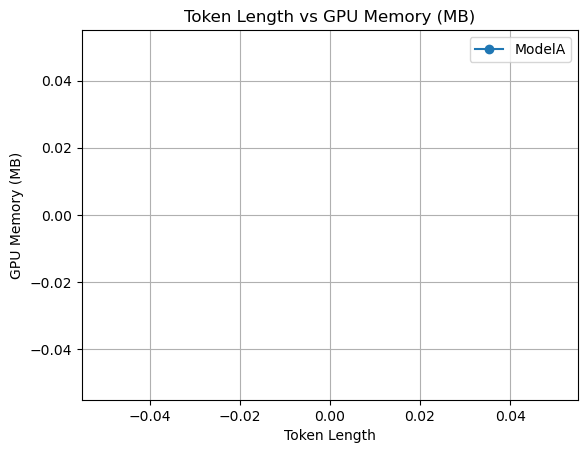

In [6]:
import torch
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
p = 0.1
# =====================
# CONFIG
# =====================
DEVICE = "cuda"
TOKEN_LENGTHS = [128, 512, 1024, 4096, 8192, 16384]
NUM_WARMUP_STEPS = 5
NUM_MEASURE_STEPS = 20
LOG_FILE = "log.txt"

# Example: three models
'''models = {
    "ModelA": model_a.to(DEVICE),
    "ModelB": model_b.to(DEVICE),
    "ModelC": model_c.to(DEVICE)
}'''

models = {
    "ModelA": model_a.to(DEVICE),
}

# Example: different tokenizers for different lengths
tokenizers = {
    128: PatchEmbed(img_size = (96, 96, 96, 2), patch_size = (24, 24, 24, 1), embed_dim = 256),
    512: PatchEmbed(img_size = (96, 96, 96, 2), patch_size = (12, 12, 24, 1), embed_dim = 256),
    1024: PatchEmbed(img_size = (96, 96, 96, 2), patch_size = (12, 12, 12, 1), embed_dim = 256),
    4096: PatchEmbed(img_size = (96, 96, 96, 2), patch_size = (6, 6, 12, 1), embed_dim = 256),
    8192: PatchEmbed(img_size = (96, 96, 96, 2), patch_size = (6, 6, 6, 1), embed_dim = 256),
    16384: PatchEmbed(img_size = (96, 96, 96, 2), patch_size = (3, 6, 6, 1), embed_dim = 256)
}

# =====================
# HELPER: Append to log
# =====================
def log_result(text):
    print(text)
    with open(LOG_FILE, "a") as f:
        f.write(text + "\n")

# =====================
# HELPER: Measure throughput + memory
# =====================
def benchmark_model(model, dataloader):
    # Warm-up
    print('warming up...')
    for i, batch in zip(range(NUM_WARMUP_STEPS), dataloader):
        #batch = {k: v.to(DEVICE) for k, v in batch.items()}
        batch = {k: (v.to(DEVICE) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        gt_full = batch.pop('fmri_sequence')
        #gt = data
        B = gt_full.shape[0]

        # Flatten spatial dims for sampling
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        coord_flat = coord.view(B, -1, coord.shape[-1])  # (B, N, dim), N=Z*H*W*T
        
        gt = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')  # (B, Z, H, W, T, C)
        gt_flat = gt.view(B, -1, gt.shape[-1])  # (B, N, C)
    
        N = coord_flat.shape[1]
        sample_size = max(1, int(p * N))  # at least sample 1 coord
    
        # Random indices to sample, same number for each batch element
        indices = torch.randperm(N, device=gt.device)[:sample_size]  # (sample_size,)
    
        # Index coords and gt
        coord_sampled = coord_flat[:, indices, :]  # (B, sample_size, dim)
        gt_sampled = gt_flat[:, indices, :]       # (B, sample_size, C)
        
        pred = model(gt_full, coord_sampled)

        #pred = hyponet(coord, tokens) # b h w 3
        #gt = einops.rearrange(gt, 'b c z h w t -> b z h w t c')
        mses = ((pred - gt_sampled)**2).view(B, -1).mean(dim=-1)
        loss = mses.mean()
        #loss = model(batch['fmri_sequence']).loss
        loss.backward()
        torch.cuda.synchronize()

    # Measurement
    torch.cuda.reset_peak_memory_stats()
    start = time.time()

    total_tokens = 0
    total_samples = 0
    
    print('measuring data...')
    for i, batch in zip(range(NUM_MEASURE_STEPS), dataloader):
        #batch = {k: v.to(DEVICE) for k, v in batch.items()}
        batch = {k: (v.to(DEVICE) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        gt_full = batch.pop('fmri_sequence')
        #gt = data
        B = gt_full.shape[0]

        # Flatten spatial dims for sampling
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        coord_flat = coord.view(B, -1, coord.shape[-1])  # (B, N, dim), N=Z*H*W*T
        
        gt = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')  # (B, Z, H, W, T, C)
        gt_flat = gt.view(B, -1, gt.shape[-1])  # (B, N, C)
    
        N = coord_flat.shape[1]
        sample_size = max(1, int(p * N))  # at least sample 1 coord
    
        # Random indices to sample, same number for each batch element
        indices = torch.randperm(N, device=gt.device)[:sample_size]  # (sample_size,)
    
        # Index coords and gt
        coord_sampled = coord_flat[:, indices, :]  # (B, sample_size, dim)
        gt_sampled = gt_flat[:, indices, :]       # (B, sample_size, C)
        
        pred = model(gt_full, coord_sampled)

        #pred = hyponet(coord, tokens) # b h w 3
        #gt = einops.rearrange(gt, 'b c z h w t -> b z h w t c')
        mses = ((pred - gt_sampled)**2).view(B, -1).mean(dim=-1)
        loss = mses.mean()
        
        #tokens = batch["input_ids"].numel()
        #samples = batch["input_ids"].shape[0]
        #total_tokens += tokens
        #total_samples += samples

        #loss = model(batch['fmri_sequence']).loss
        loss.backward()
        torch.cuda.synchronize()

    elapsed = time.time() - start
    max_mem = torch.cuda.max_memory_allocated() / (1024**2)  # MB

    #tokens_per_sec = total_tokens / elapsed
    #samples_per_sec = total_samples / elapsed

    return max_mem
    #return max_mem, tokens_per_sec, samples_per_sec


# =====================
# MAIN BENCHMARK LOOP
# =====================
results = {name: [] for name in models.keys()}

# Clear previous log
with open(LOG_FILE, "w") as f:
    f.write("Benchmark Results Log\n")
    f.write("="*50 + "\n")

for token_len in TOKEN_LENGTHS:
    log_result(f"\n=== Token Length: {token_len} ===")
    tokenizer = tokenizers[token_len].to(DEVICE)


    data_module = DataModule('./cfgs/hcp_data_all_config.yaml')
    data_module.setup()
    dataloader = data_module.train_dataloader()

    for model_name, model in models.items():
        log_result(f"Benchmarking {model_name}...")
        model.set_patchifier(tokenizer)
        model.eval()
        torch.cuda.empty_cache()

        try:
            mem = benchmark_model(model, dataloader)
            log_result(f"Memory: {mem:.2f} MB")

            results[model_name].append({
                "token_length": token_len,
                "gpu_memory_mb": mem
            })

        except torch.cuda.OutOfMemoryError:
            log_result(f"⚠️  OOM at token length {token_len} for {model_name}")
            torch.cuda.empty_cache()
            results[model_name].append({
                "token_length": token_len,
                "gpu_memory_mb": None,
            })
            '''mem, tok_sec, samp_sec = benchmark_model(model, dataloader)
            log_result(f"Memory: {mem:.2f} MB | Throughput: {tok_sec:.2f} tok/s, {samp_sec:.2f} samples/s")

            results[model_name].append({
                "token_length": token_len,
                "gpu_memory_mb": mem,
                "tokens_per_sec": tok_sec
            })

        except torch.cuda.OutOfMemoryError:
            log_result(f"⚠️  OOM at token length {token_len} for {model_name}")
            torch.cuda.empty_cache()
            results[model_name].append({
                "token_length": token_len,
                "gpu_memory_mb": None,
                "tokens_per_sec": None
            })'''


# =====================
# PLOT RESULTS
# =====================
'''for metric, ylabel in [("gpu_memory_mb", "GPU Memory (MB)"), ("tokens_per_sec", "Throughput (tokens/sec)")]:
    plt.figure()
    for model_name in models.keys():
        x_vals = [r["token_length"] for r in results[model_name]]
        y_vals = [r[metric] if r[metric] is not None else float("nan") for r in results[model_name]]
        plt.plot(
            x_vals,
            y_vals,
            marker='o',
            label=model_name
        )
    plt.xlabel("Token Length")
    plt.ylabel(ylabel)
    plt.title(f"Token Length vs {ylabel}")
    plt.legend()
    plt.grid(True)
    plt.show()'''
for metric, ylabel in [("gpu_memory_mb", "GPU Memory (MB)")]:
    plt.figure()
    for model_name in models.keys():
        x_vals = [r["token_length"] for r in results[model_name]]
        y_vals = [r[metric] if r[metric] is not None else float("nan") for r in results[model_name]]
        plt.plot(
            x_vals,
            y_vals,
            marker='o',
            label=model_name
        )
    plt.xlabel("Token Length")
    plt.ylabel(ylabel)
    plt.title(f"Token Length vs {ylabel}")
    plt.legend()
    plt.grid(True)
    plt.show()